## Volatility regime detection with Hidden Markov Model ##



Paulo Yoshio Kuga


**Abstract**

In this notebook, it is presented a methodology of volatility regime identification using Gaussian Hidden Markov Models (GHMM). Two methods of volatility calculation are presented over the IBOVESPA index. The interest of modelling volatility as a Hidden Markov Model is the fact that, different from GARCH, GHMM are more flexible to describe volatility jumps. Nonetheless, it is possible to estimate the probability of a state, giving a insightful notion about uncertainty over the identification. It is concluded that different approaches on volatility modelling can impact the GHMM results.

Firstly, we import our libraries:

In [9]:
import pandas as pd
from matplotlib import pyplot as plt
import bandeirante as bd
import numpy as np

from hmmlearn.hmm import GaussianHMM

import yfinance as yf

from datetime import datetime

Then it is possible to download our dataset through Yahoo Finance (yfinance). We can choose IBOVESPA (^BVSP) as a asset to volatility calculation. A window of approximately 5 years is selected. This data is 1 day interval.

In [10]:
start_date = datetime(2021,1,1)
end_date = datetime.today()

ticker = "^BVSP"

dataset = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    interval="1d"
    ).droplevel(axis=1,level=1)


[*********************100%***********************]  1 of 1 completed


Next, we can calculate our volatility through two approaches. The first one is the standard deviation of the asset log-returns (Close-to-Close). This approach is the classical statistcal one. The second approach is to use Parkinson volatility, which can be calculated through Bandeirante library. We can select a window of 21 days (approximately the business days on month) and perform the calculations.

In [11]:
w = 21 #general volatility window

dataset["returns"] = dataset["Close"].pct_change().add(1).apply(np.log).dropna()
dataset["vol_std"] = dataset.returns.rolling(w).std().dropna()

dataset["vol_park"] = bd.parkinson(dataset,w,maxStr="High",minStr="Low")

dataset.dropna(inplace=True) #to assure consistency along the dataset

We can plot the log-returns and the two types of volatility. It is possible to notice that, usually, Parkinson volatility tends to be more conservative along the time. It is known that statistical standard deviation volatility tends to superestimate volatility true value.

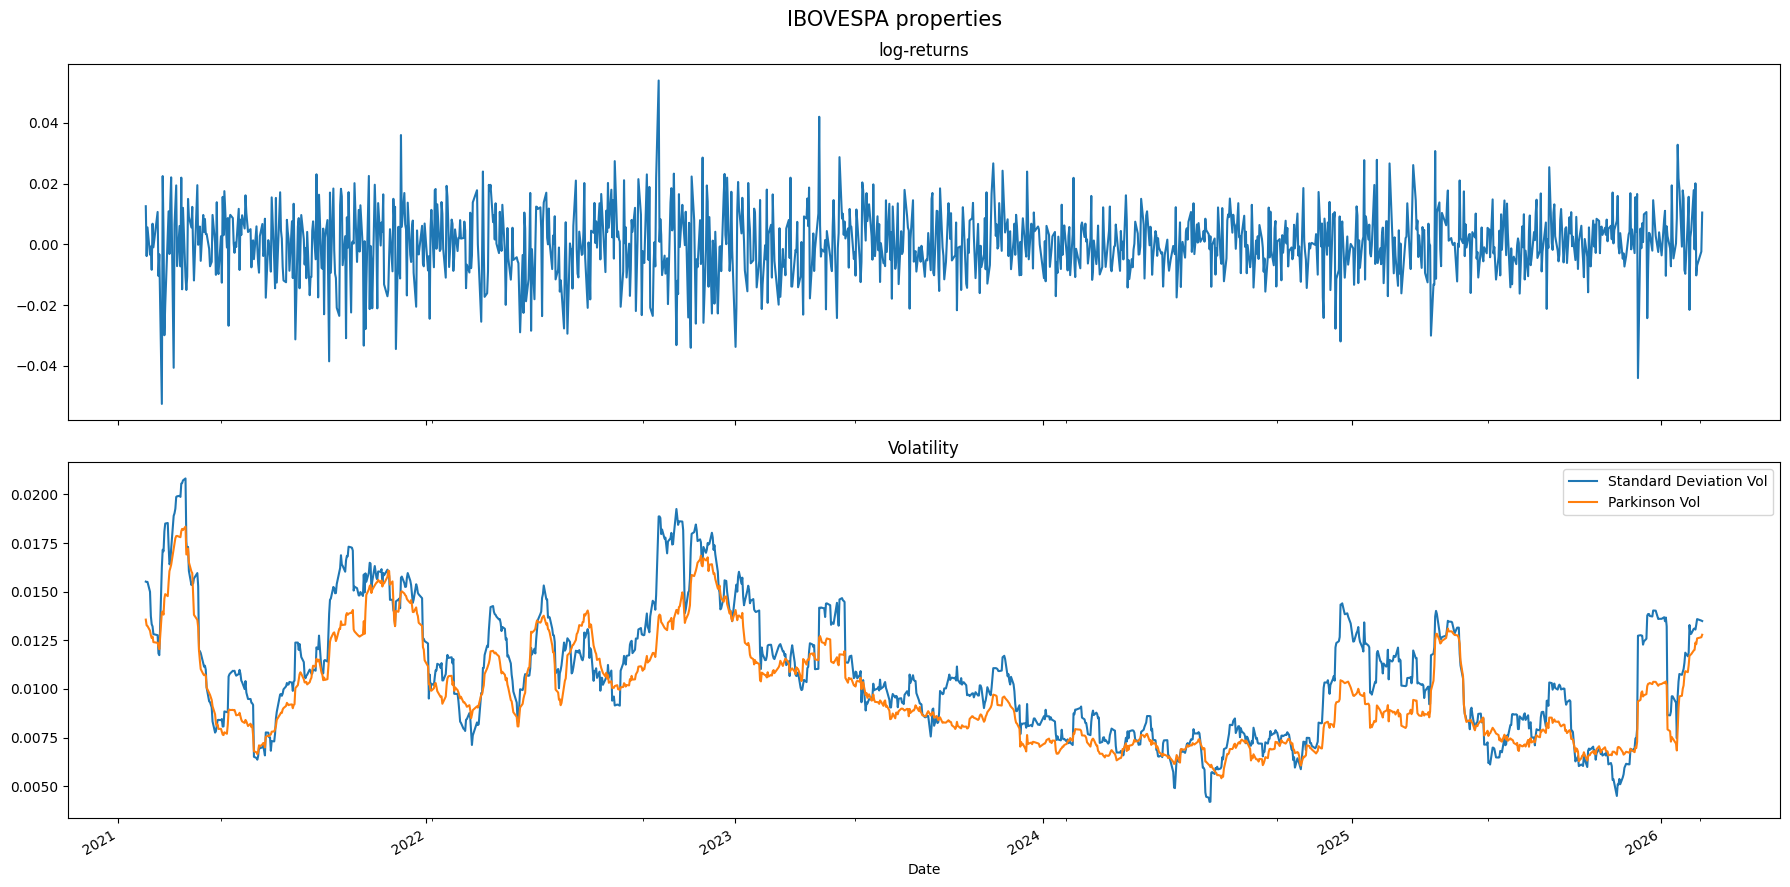

In [12]:
fig,axs = plt.subplots(2,1, figsize=(18,9),sharex=True)

dataset["returns"].plot(ax=axs[0])
dataset["vol_std"].plot(ax=axs[1])
dataset["vol_park"].plot(ax=axs[1])


fig.suptitle("IBOVESPA properties",fontsize=15)

axs[0].set_title("log-returns")
axs[1].set_title("Volatility")

axs[1].legend(["Standard Deviation Vol","Parkinson Vol"])


fig.tight_layout()

Also, we can observe the volatility distributions. It is possible to notice that the distributions are different, but Parkinson tends to be a skew with less extreme values. 

array([[<Axes: title={'center': 'vol_std'}>,
        <Axes: title={'center': 'vol_park'}>]], dtype=object)

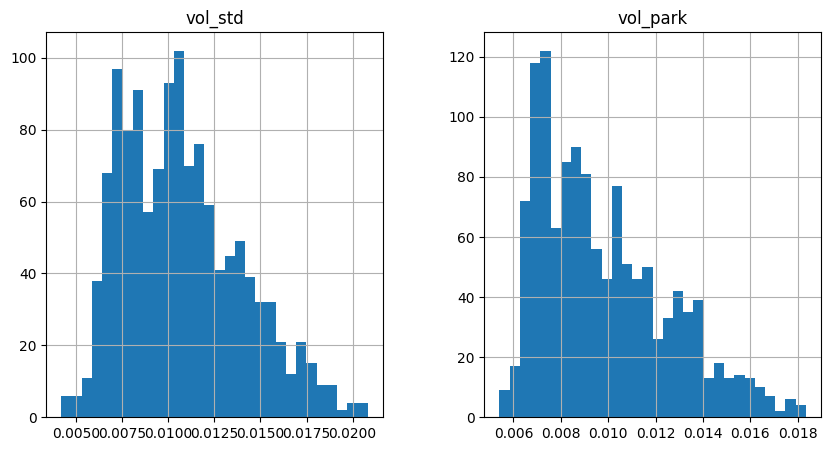

In [13]:
dataset[["vol_std","vol_park"]].hist(bins=30,figsize=(10,5))

Next, we can set our GHMM model. Essentialy, we can define the number of states of our model, and the percentual of the dataset that will be relative to the train sequence. Indeed, in this notebook, we are considering the sequence as a whole, even it being separated by the weekends. Parkinson volatility is a model which does not consider overnights as well. $hmmlearn$ has a possibility to determine sequence lengths to state determination.

Another relevant aspects, are the fact that we use a "anti_stall" variable which allows the hidden markov model to not deal with small values, what can lead to a convergence problem. Moreover, we define the states numeration based on the stationary distribution of the model, in a way that we can compare both models.

In [14]:
def hmm_model_generator(
        vol, 
        n = 2,
        anti_stall = 1e6,
        train_test_percentual = 0.7,
        random_state = 0
        ):

    X = vol.to_numpy().reshape(-1,1)*anti_stall

    series_length,_ = X.shape  

    cut_value = int(np.ceil((series_length*train_test_percentual)))

    X_train= X[:cut_value]

    hmm_model = GaussianHMM(n_components=n,covariance_type="full",random_state=random_state)

    hmm_model.fit(X_train)

    return hmm_model,X, cut_value


def state_as_stationary(hmm_model,n_states):
    stationary = hmm_model.get_stationary_distribution()

    states_order = dict(
    zip(
        np.argsort(stationary)[::-1],np.array(range(0,n_states))
        )
    )
    order_function = np.vectorize(states_order.get)

    return order_function


We set our number of states as 3 for Close-to-Close volatility. For Parkinson, we set 4 states. The difference is due to the convergence of each model for data. Even by changing random state, we still might deal with state chattering (the reader is invited to try different parameters to observe this behaviour). 

We predict the states for the entire series, and when predicting, re-ordering the states to adhere our convention.

In [15]:
n_states_std = 3
n_states_parkinson = 4

hmm_model_std, X_std, cut_value, = hmm_model_generator(dataset.vol_std,n=n_states_std,random_state=20000827)
hmm_model_parkinson, X_parkinson, _ = hmm_model_generator(dataset.vol_park,n=n_states_parkinson, random_state=0)

prediction_std = state_as_stationary(hmm_model_std,n_states_std)(hmm_model_std.predict(X_std))
prediction_parkinson = state_as_stationary(hmm_model_parkinson,n_states_parkinson)(hmm_model_parkinson.predict(X_parkinson))


dataset["state_std"] = prediction_std
dataset["state_park"] = prediction_parkinson

And then, using add_state_background function in Bandeirante, we can plot our states as coloured backgrounds:

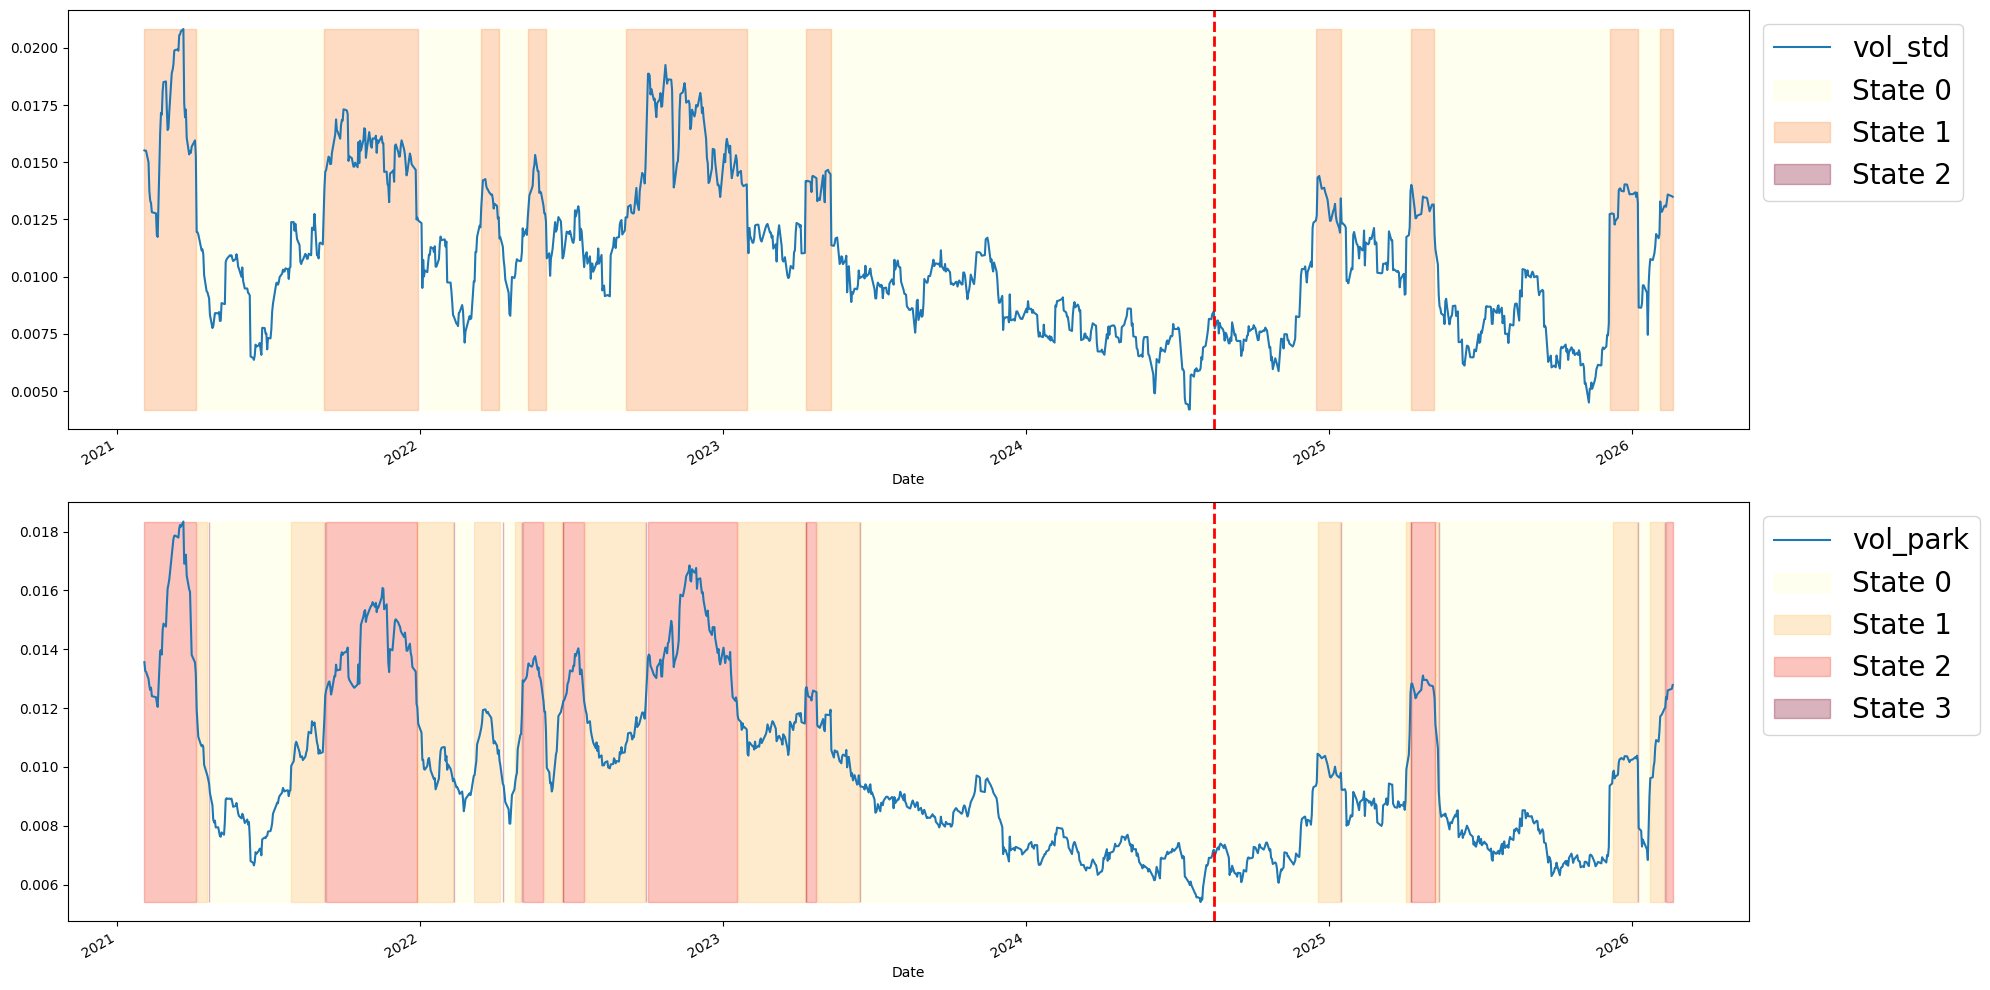

In [16]:
fig,axs = plt.subplots(2,1,figsize=(20,10))

dataset["vol_std"].plot(ax=axs[0])
dataset["vol_park"].plot(ax=axs[1])

pallette = "YlOrRd"

bd.add_state_background(dataset,"vol_std","state_std",n=n_states_std,ax=axs[0],chosenPallete=pallette)

bd.add_state_background(dataset,"vol_park","state_park",n=n_states_parkinson,ax=axs[1],chosenPallete=pallette)

axs[0].axvline(x=dataset.index[cut_value], color='r', linestyle='dashed', linewidth=2)
axs[1].axvline(x=dataset.index[cut_value], color='r', linestyle='dashed', linewidth=2)

plt.tight_layout()